# Basic imports
---

In [42]:
import os
import torch
import pandas as pd

import torch.nn.functional as F
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import CSVLogger

import matplotlib.pyplot as plt
import cv2
import numpy as np

ABS_PATH_DATASET = "~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets"  # replace with your path to the first folder of the repo dataset
ABS_PATH_DATASET = os.path.expanduser(ABS_PATH_DATASET)

## Device detection

In [2]:
# Device detection: prefer CUDA -> Apple MPS (macOS M series) -> CPU
cuda_available = torch.cuda.is_available()
mps_available = getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available()

if cuda_available:
    device = torch.device("cuda")
    accelerator = "gpu"
    devices = 1
elif mps_available:
    device = torch.device("mps")
    accelerator = "mps"
    devices = 1
else:
    device = torch.device("cpu")
    accelerator = "cpu"
    devices = None

pin_memory = True if cuda_available else False

print(f"Using device={device} (cuda={cuda_available}, mps={mps_available}), accelerator={accelerator}, devices={devices}")

Using device=mps (cuda=False, mps=True), accelerator=mps, devices=1


# Download and process the data set
---



## Download from github

In [ ]:
!git clone https://github.com/octavio-navarro/DL_Data_sets.git

## Locally (bash)

In [41]:
!curl -sSL https://github.com/octavio-navarro/DL_Data_sets/archive/refs/heads/main.zip -o DL_Data_sets.zip
!unzip -q DL_Data_sets.zip -d ~/src/tec/semestre_7_local/ds_ai_ml_models/DL_Data_sets # replace with your path to the first folder of the repo dataset
!rm DL_Data_sets.zip

## Show an image from the data set

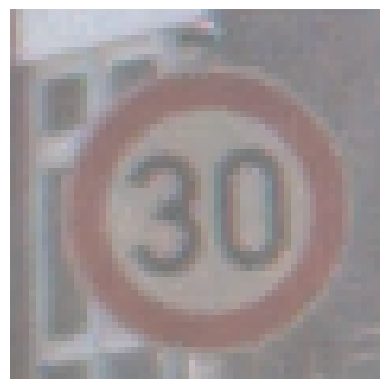

In [3]:
img_path = ABS_PATH_DATASET + '/DL_Data_sets-main/German_Traffic_signs/Images/00001/00000_00003.ppm'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()


## Separates the data into different folders

In [ ]:
# Generated with ChatGPT-5 mini
import os, shutil, random

def split_counts(n: int, train: float, eval: float, test: float):
    t = int(n * train)
    e = int(n * eval)
    return t, e, n - t - e

def is_image_file(name: str) -> bool:
    return name.lower().endswith(('.png', '.jpg', '.jpeg', '.ppm', '.bmp', '.gif', '.tif', '.tiff'))

def process(src: str, dst: str, p_train: float = 0.7, p_eval: float = 0.1, p_test: float = 0.2, seed: int = 42):
    src = os.path.expanduser(src)
    dst = os.path.expanduser(dst)
    os.makedirs(dst, exist_ok=True)
    random.seed(seed)
    totals = {}
    classes = [d for d in sorted(os.listdir(src)) if os.path.isdir(os.path.join(src, d))]
    for cls in classes:
        cls_src = os.path.join(src, cls)
        files = [f for f in sorted(os.listdir(cls_src)) if is_image_file(f) and os.path.isfile(os.path.join(cls_src, f))]
        random.shuffle(files)
        n_train, n_eval, n_test = split_counts(len(files), p_train, p_eval, p_test)
        splits = {'train': files[:n_train], 'eval': files[n_train:n_train+n_eval], 'test': files[n_train+n_eval:]}
        for split_name, split_files in splits.items():
            target_dir = os.path.join(dst, split_name, cls)
            os.makedirs(target_dir, exist_ok=True)
            for fname in split_files:
                shutil.copy2(os.path.join(cls_src, fname), os.path.join(target_dir, fname))
        totals[cls] = len(files)
        print(f'class {cls}: total={len(files)} -> train={n_train}, eval={n_eval}, test={n_test}')
    return totals

src = ABS_PATH_DATASET + '/DL_Data_sets-main/German_Traffic_signs/Images'
dst = ABS_PATH_DATASET + '/DL_Data_sets-main/German_Traffic_signs/ordered'
process(src, dst, p_train=0.7, p_eval=0.1, p_test=0.2, seed=42)


class 00000: total=210 -> train=147, eval=21, test=42
class 00001: total=2220 -> train=1554, eval=222, test=444
class 00002: total=2250 -> train=1575, eval=225, test=450
class 00003: total=1410 -> train=986, eval=141, test=283
class 00004: total=1980 -> train=1386, eval=198, test=396
class 00005: total=1860 -> train=1302, eval=186, test=372
class 00006: total=420 -> train=294, eval=42, test=84
class 00007: total=1440 -> train=1007, eval=144, test=289
class 00008: total=1410 -> train=986, eval=141, test=283
class 00009: total=1470 -> train=1029, eval=147, test=294
class 00010: total=2010 -> train=1407, eval=201, test=402
class 00011: total=1320 -> train=923, eval=132, test=265
class 00012: total=2100 -> train=1470, eval=210, test=420
class 00013: total=2160 -> train=1512, eval=216, test=432
class 00014: total=780 -> train=546, eval=78, test=156
class 00015: total=630 -> train=441, eval=63, test=126
class 00016: total=420 -> train=294, eval=42, test=84
class 00017: total=1110 -> train=77

### Analyze dataset class distribution, and also image measures for every class

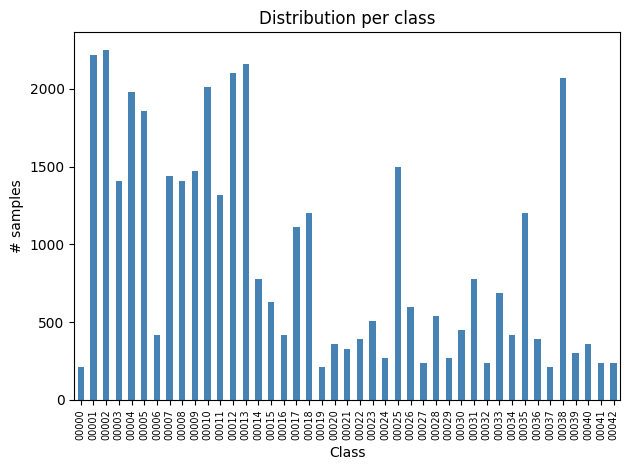

Stats:
Total dataset samples: 39209
Total labels: 43
Class with less samples: 210 (class 00000)
Class with more samples: 2250 (class 00002)
Average samples per class: 911.8

Images measures and statistic analysis for them:
Width: min=25, max=243, mean=50.8, std=24.4
Height:  min=25, max=225, mean=50.3, std=23.2


split,eval,test,train,total
class,,,,
00000,21,42,147,210
00001,222,444,1554,2220
00002,225,450,1575,2250
00003,141,283,986,1410
00004,198,396,1386,1980
00005,186,372,1302,1860
00006,42,84,294,420
00007,144,289,1007,1440
00008,141,283,986,1410


In [48]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import numpy as np

def analyze_dataset(data_dir):
    data_dir = os.path.expanduser(data_dir)
    splits = ['train', 'eval', 'test']
    
    records = []
    for split in splits:
        split_dir = os.path.join(data_dir, split)
        if not os.path.exists(split_dir):
            continue
        for cls in sorted(os.listdir(split_dir)):
            cls_dir = os.path.join(split_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.ppm'))]
            records.append({'class': cls, 'split': split, 'count': len(files)})
    
    df = pd.DataFrame(records)
    df_pivot = df.pivot(index='class', columns='split', values='count').fillna(0).astype(int)
    df_pivot['total'] = df_pivot.sum(axis=1)
    
    df_pivot['total'].plot(kind='bar', color='steelblue')
    plt.title('Distribution per class')
    plt.xlabel('Class')
    plt.ylabel('# samples')
    plt.xticks(rotation=90, fontsize=7)
    
    plt.tight_layout()
    plt.show()
    
    # Stats rápidos
    print("Stats:")
    print(f"Total dataset samples: {df_pivot['total'].sum()}")
    print(f"Total labels: {len(df_pivot)}")
    print(f"Class with less samples: {df_pivot['total'].min()} (class {df_pivot['total'].idxmin()})")
    print(f"Class with more samples: {df_pivot['total'].max()} (class {df_pivot['total'].idxmax()})")
    print(f"Average samples per class: {df_pivot['total'].mean():.1f}")
    
    return df_pivot

def sample_image_dims(data_dir):
    data_dir = os.path.expanduser(data_dir)
    train_dir = os.path.join(data_dir, 'train')
    files = []
    for cls in os.listdir(train_dir):
        cls_dir = os.path.join(train_dir, cls)
        if os.path.isdir(cls_dir):
            cls_files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.lower().endswith(('.png','.jpg','.jpeg','.ppm'))]
            files.extend(cls_files)
    
    dims = []
    for path in files:
        try:
            with Image.open(path) as img:
                dims.append(img.size)
        except:
            pass
    
    dims = np.array(dims)
    print(f"\nImages measures and statistic analysis for them:")
    print(f"Width: min={dims[:,0].min()}, max={dims[:,0].max()}, mean={dims[:,0].mean():.1f}, std={dims[:,0].std():.1f}")
    print(f"Height:  min={dims[:,1].min()}, max={dims[:,1].max()}, mean={dims[:,1].mean():.1f}, std={dims[:,1].std():.1f}")

dataset_path = ABS_PATH_DATASET + '/DL_Data_sets-main/German_Traffic_signs/ordered'
df_dist = analyze_dataset(dataset_path)
sample_image_dims(dataset_path)
df_dist 

## Dataset analysis insights

After doing this analysis, I came to the following findings about the dataset.

While this dataset contains a lot of images, nearly 40,000, the problem is that it is very unevenly distributed. The class with the least samples amount has more than 10 times less samples than the class with the more amount of them. This can make the model to be biased to learning filters for distinguishing better images from classes with more samples.

Another thing that I noticed, is that it happens something similar with the images measures. We have images form 25 to 250px, in both width and height. THe std deviation of the images is of 23, nearly the size of the smaller image o this dataset. This can be a problem, as when we resize the images, many of them will contain repeated pixels making the image blurrier.

After the analysis, I decided to leave the dataset as it is, because in a real life situation, we may encouter more street signs of a class than another. Also, for normalizing the data, we would be stripping a lot of useful data, since the classes distributions is very uneven.


# Model definition with transfer learning
---

## Define a model to classify the images. **Use transfer learning for this step, but don't use fine-tuning.**


In [5]:
resnet_transfer_learning_model = torch.hub.load("pytorch/vision", "resnet18", weights=None) # 'IMAGENET1K_V1'

Using cache found in /Users/marcosdayanmann/.cache/torch/hub/pytorch_vision_main


In [6]:
# for param in resnet_model.parameters():
#     param.requires_grad = False # no entrenar
    # print( param)

In [7]:
resnet_transfer_learning_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
dataset_path = ABS_PATH_DATASET + '/DL_Data_sets-main/German_Traffic_signs/ordered'
classes = os.listdir(os.path.join(dataset_path, 'train'))
resnet_transfer_learning_model.fc = torch.nn.Linear(512, len(classes)) # modificar el número de clases a las que tenemos
resnet_transfer_learning_model.fc

Linear(in_features=512, out_features=43, bias=True)

In [9]:
class ResnetModelLightning(L.LightningModule):
    def __init__(self, model, learning_rate, num_classes=43):
        """Initialize the ResnetModel class.

            Args:
                model (torch.nn.Module): The CNN model to be used for training and inference.
                learning_rate (float): The learning rate for the optimizer.
        """
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        """Forward pass of the model.

            Args:
                x (torch.Tensor): Input tensor of shape (batch_size, 1, 28, 28)

            Returns:
                torch.Tensor: Output tensor after passing through the model
        """
        return self.model(x)

    def _shared_step(self, batch): # agrupar partes iguales de train y val
        features, true_labels = batch
        # true_labels = true_labels - 1
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        """Perform a training step.

            Args:
                batch: A batch of training data containing features and labels.
                batch_idx (int): Index of the current batch in the epoch.

            Returns:
                torch.Tensor: Loss tensor to be optimized
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        """Perform a validation step.

            Args:
                batch: A batch of validation data containing features and labels.
                batch_idx (int): Index of the current batch in the validation set.

            Returns:
                torch.Tensor: Validation loss tensor
        """
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        with torch.no_grad():
            loss, true_labels, predicted_labels = self._shared_step(batch)
            self.test_acc(predicted_labels, true_labels)
            self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        """Configure the optimizer for training.

            Returns:
                torch.optim.Optimizer: Optimizer for training
        """
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.learning_rate) # optimizar muy común para imágenes, variación de SGD (stochastic gradient descent)
        return optimizer

## Define the data augmentation transformations for the data loaders.

In [ ]:
import torchvision.transforms as transforms

train_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.RandomCrop((128, 128)),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0, 1] -> [-1, 1]
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

## Define the train, validation, and test dataloaders

In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

class ResnetDataModule(L.LightningDataModule):
    def __init__(self, data_dir=None, batch_size=64, num_workers=4, train_transform=None, test_transform=None, pin_memory=False):
        super().__init__()
        base = ABS_PATH_DATASET + '/DL_Data_sets-main/German_Traffic_signs/ordered'
        self.data_dir = os.path.expanduser(base) if data_dir is None else os.path.expanduser(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.num_classes = None  # inicializar
        self.pin_memory = pin_memory
        self.setup()

    def setup(self, stage=None):
        train_dir = os.path.join(self.data_dir, 'train')
        val_dir = os.path.join(self.data_dir, 'eval')
        test_dir = os.path.join(self.data_dir, 'test')

        self.train = ImageFolder(train_dir, transform=self.train_transform)
        self.val = ImageFolder(val_dir, transform=self.test_transform)
        self.test = ImageFolder(test_dir, transform=self.test_transform)

        self.num_classes = len(self.train.classes)

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            persistent_workers=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            persistent_workers=True,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            drop_last=False,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=self.pin_memory
        )

## Using matplotlib, visualize images from the train dataloader. Create a figure of 20 images, with 5 images per row.

batch shapes -> images: torch.Size([32, 3, 128, 128]) labels: torch.Size([32])


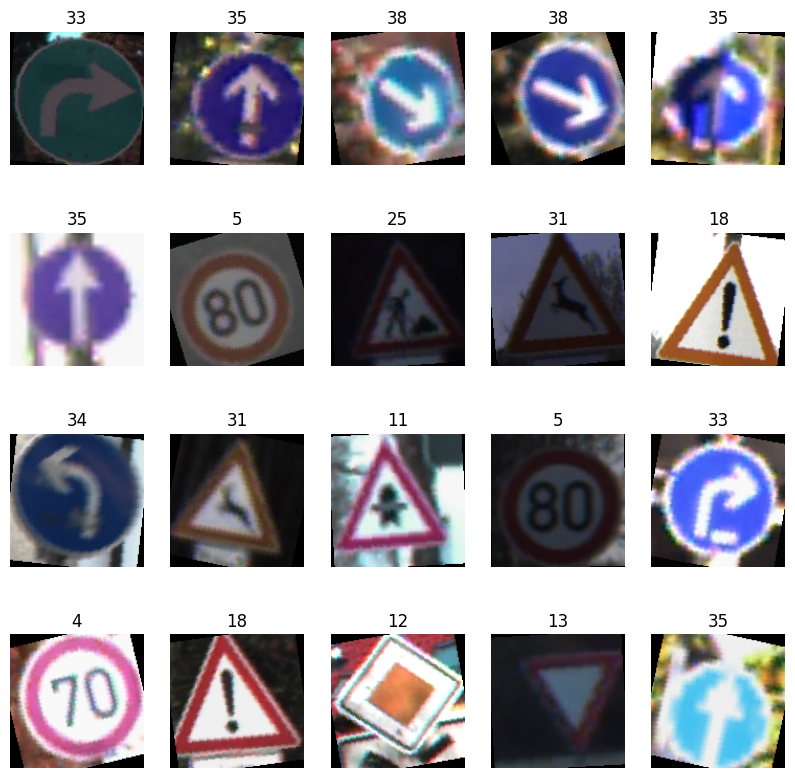

In [12]:
# Inicializa el DataModule, muestra num_classes y 6 imágenes de ejemplo del train loader
dm = ResnetDataModule(batch_size=32, train_transform=train_transform, test_transform=test_transform, pin_memory=pin_memory)

loader = dm.train_dataloader()
images, labels = next(iter(loader))

# print(len(images))
print('batch shapes -> images:', images.shape, 'labels:', labels.shape)

inv = lambda x: x * 0.5 + 0.5

n = min(20, images.size(0))
fig, axes = plt.subplots(4, 5, figsize=(10, 10))


for i in range(n):
    r, c = divmod(i, 5)
    img = inv(images[i]).permute(1, 2, 0).cpu().numpy()
    axes[r, c].imshow(img)
    axes[r, c].set_title(str(labels[i].item()))
    axes[r, c].axis('off')
plt.show()

## Train the model. Use model checkpoints and early stopping during training. **Don't forget to use a GPU for training.**

In [19]:
# TODO: Train the model.

dm = ResnetDataModule(batch_size=32, train_transform=train_transform, test_transform=test_transform, pin_memory=pin_memory)


resnet_model_lightning = ResnetModelLightning(
    model=resnet_transfer_learning_model,
    learning_rate=0.01,
    num_classes=dm.num_classes
)


print(f"device={device}, accelerator={accelerator}, devices={devices}")

trainer_resnet_transfer_learning = L.Trainer(
    accelerator=accelerator, 
    devices=devices or 0,
    logger=CSVLogger(save_dir="logs/", name="german-traffic-lights-resnet-transfer-learning-model"),
    max_epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


device=mps, accelerator=mps, devices=1


In [20]:
trainer_resnet_transfer_learning.fit(model=resnet_model_lightning, datamodule=dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.794    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 857/857 [00:49<00:00, 17.31it/s, v_num=1, val_loss=0.0216, val_acc=0.995, train_acc=0.991] 


## Model evaluation
---

### Evaluate the performance of the model with the test dataloader.

In [46]:
# TODO: Evaluate the model, and print the results.

trainer_resnet_transfer_learning.test(datamodule=dm)

Restoring states from the checkpoint path at logs/german-traffic-lights-resnet-transfer-learning-model/version_0/checkpoints/epoch=9-step=8570.ckpt
Loaded model weights from the checkpoint at logs/german-traffic-lights-resnet-transfer-learning-model/version_0/checkpoints/epoch=9-step=8570.ckpt


Testing DataLoader 0: 100%|██████████| 246/246 [00:04<00:00, 58.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9965605139732361
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9965605139732361}]

### Plot the results of training: plot training and validation accuracy, and loss.

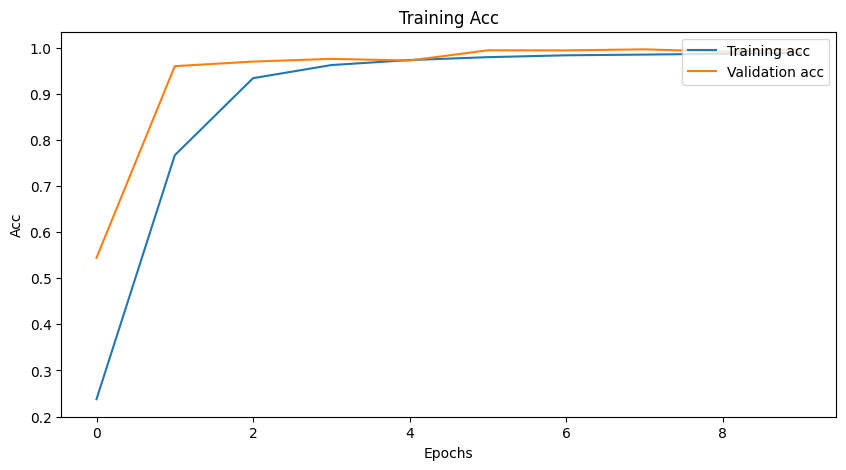

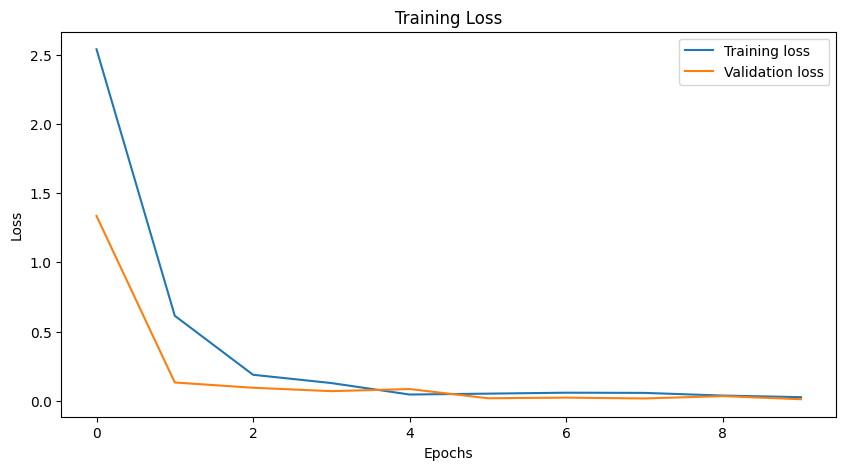

In [50]:
metrics = pd.read_csv(f"{trainer_resnet_transfer_learning.logger.log_dir}/metrics.csv")
df_epochs = metrics.groupby('epoch').mean()


# Plot the results of the training and validation accuracy.
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Acc')
# Plot the training loss over epochs
ax.plot(df_epochs['train_acc'], label="Training acc")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_acc'], label="Validation acc")
# Set the title of the plot
ax.set_title("Training Acc")
# Add a legend to the plot
ax.legend(loc='upper right')


# Plot the results of the training and validation loss.

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

# Model using Transfer Learning and fine-tuning
---

Create a model using transfer learning, data augmentation, and fine-tuning, train the model, and do predictions with it on the test dataset.

## Make and train a new model using transfer learning and fine-tuning.


In [ ]:
resnet_fine_tuning_model = torch.hub.load("pytorch/vision", "resnet18", weights="IMAGENET1K_V1")
for param in resnet_fine_tuning_model.parameters():
    param.requires_grad = False # no entrenar
    # print( param.requires_grad)
    # print( param)


resnet_fine_tuning_model.layer4.requires_grad = True



Using cache found in /Users/marcosdayanmann/.cache/torch/hub/pytorch_vision_main


In [ ]:
dataset_path = ABS_PATH_DATASET + '/DL_Data_sets-main/German_Traffic_signs/ordered'
classes = os.listdir(os.path.join(dataset_path, 'train'))
resnet_fine_tuning_model.fc = torch.nn.Linear(512, len(classes)) # modificar el número de clases a las que tenemos
resnet_fine_tuning_model.fc.requires_grad = True
resnet_fine_tuning_model.fc

Linear(in_features=512, out_features=43, bias=True)

In [15]:
# TODO: Train the model.

fine_tuning_dm = ResnetDataModule(batch_size=32, train_transform=train_transform, test_transform=test_transform, pin_memory=pin_memory)


resnet_fine_tuning_model_lightning = ResnetModelLightning(
    model=resnet_transfer_learning_model,
    learning_rate=0.01,
    num_classes=fine_tuning_dm.num_classes
)


print(f"device={device}, accelerator={accelerator}, devices={devices}")

trainer_resnet_fine_tuning = L.Trainer(
    accelerator=accelerator, 
    devices=devices or 0,
    logger=CSVLogger(save_dir="logs/", name="german-traffic-lights-resnet-fine-tuning-model"),
    max_epochs=10,
    callbacks=[EarlyStopping(monitor="val_loss", mode="min", patience=3)],
)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


device=mps, accelerator=mps, devices=1


In [16]:
trainer_resnet_fine_tuning.fit(model=resnet_fine_tuning_model_lightning, datamodule=fine_tuning_dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.794    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 857/857 [00:48<00:00, 17.54it/s, v_num=0, val_loss=0.0274, val_acc=0.995, train_acc=0.985]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 857/857 [00:49<00:00, 17.47it/s, v_num=0, val_loss=0.0274, val_acc=0.995, train_acc=0.985]


## Plot the results of training and evaluation

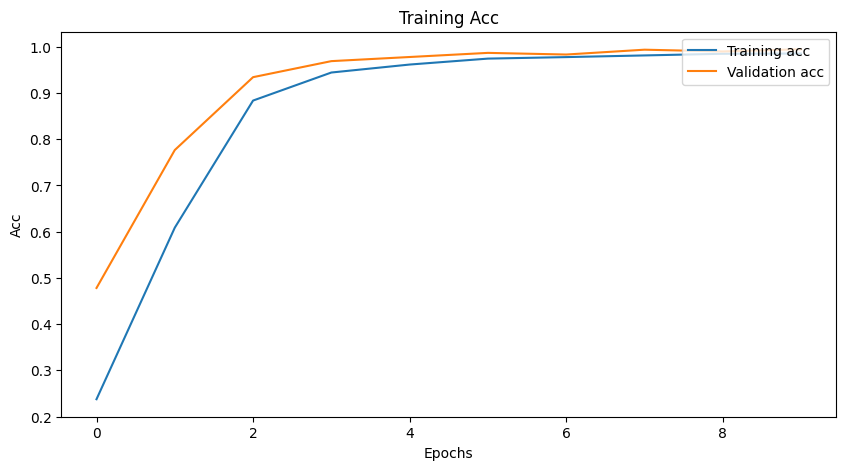

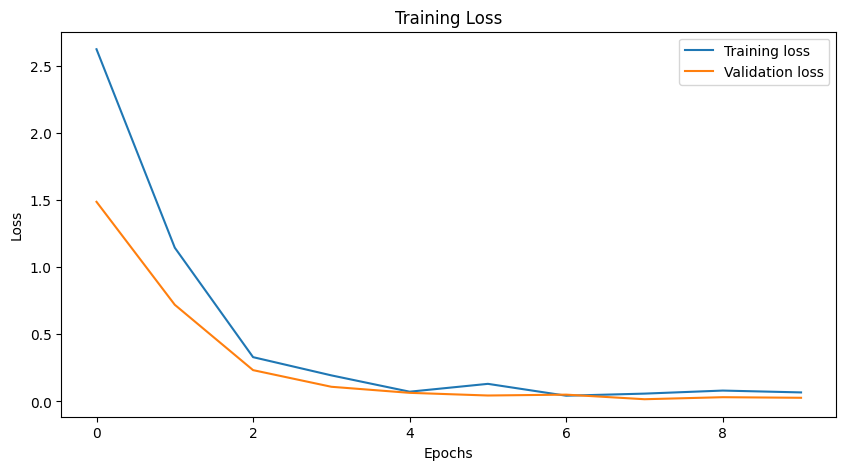

In [17]:
# TODO: Plot training and print the evaluation results
metrics = pd.read_csv(f"{trainer_resnet_fine_tuning.logger.log_dir}/metrics.csv")
df_epochs = metrics.groupby('epoch').mean()


# Plot the results of the training and validation accuracy.
# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Acc')
# Plot the training loss over epochs
ax.plot(df_epochs['train_acc'], label="Training acc")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_acc'], label="Validation acc")
# Set the title of the plot
ax.set_title("Training Acc")
# Add a legend to the plot
ax.legend(loc='upper right')


# Plot the results of the training and validation loss.

# Create a figure and axis for plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Set the x-axis label
ax.set_xlabel('Epochs')
# Set the y-axis label
ax.set_ylabel('Loss')
# Plot the training loss over epochs
ax.plot(df_epochs['train_loss'], label="Training loss")
# Plot the validation loss over epochs
ax.plot(df_epochs['val_loss'], label="Validation loss")
# Set the title of the plot
ax.set_title("Training Loss")
# Add a legend to the plot
ax.legend(loc='upper right')

## Makes predictions using the test dataset

In [18]:
# TODO: Make predictions
trainer_resnet_fine_tuning.test(datamodule=fine_tuning_dm)

/Users/marcosdayanmann/src/tec/semestre_7_local/ds_ai_ml_models/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:149: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at logs/german-traffic-lights-resnet-fine-tuning-model/version_0/checkpoints/epoch=9-step=8570.ckpt
Loaded model weights from the checkpoint at logs/german-traffic-lights-resnet-fine-tuning-model/version_0/checkpoints/epoch=9-step=8570.ckpt
/Users/marcosdayanmann/src/tec/semestre_7_local/ds_ai_ml_models/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:428: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 246/246 [00:04<00:00, 53.02it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9924840927124023
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9924840927124023}]

# Compare the performance of both models
---

Plot the results of both models in the same figure.

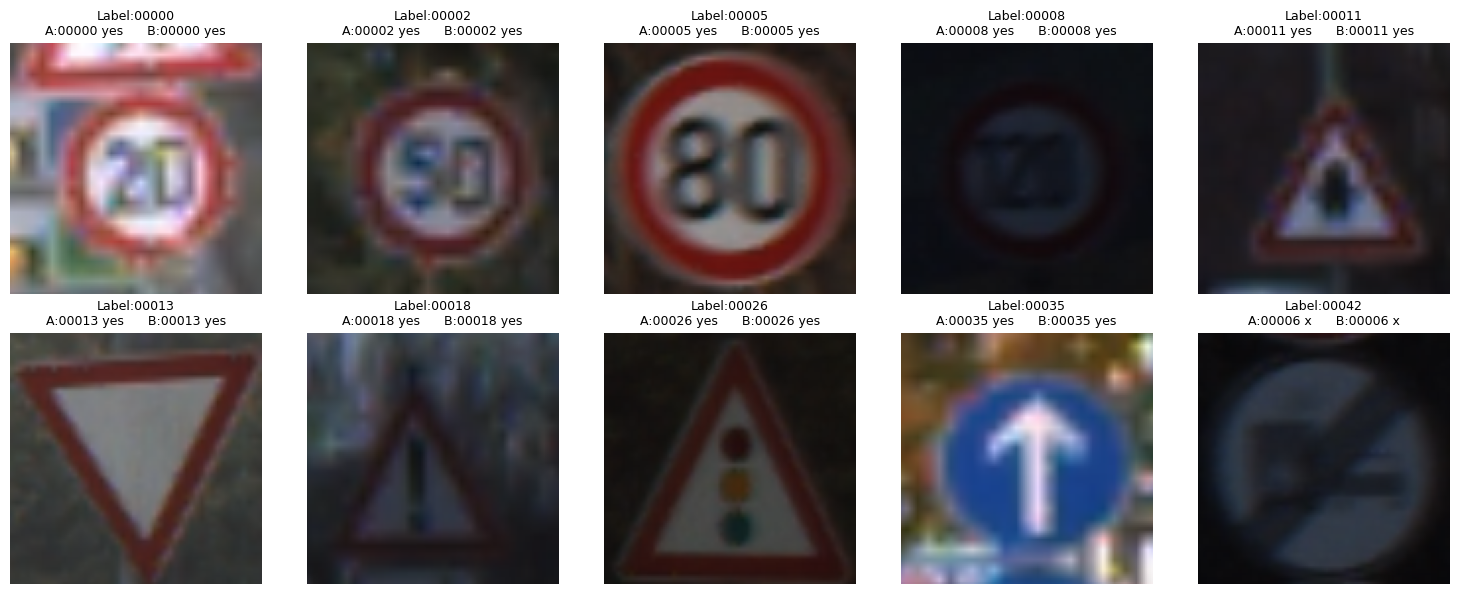

,index,true,pred_a,pred_b,corr_a,corr_b
0,0,0,0,0,True,True
1,872,2,2,2,True,True
2,1744,5,5,5,True,True
3,2616,8,8,8,True,True
4,3488,11,11,11,True,True
5,4360,13,13,13,True,True
6,5232,18,18,18,True,True
7,6104,26,26,26,True,True
8,6976,35,35,35,True,True
9,7849,42,6,6,False,False


In [ ]:
# made with ChatGPT 5 mini
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def compare_and_plot_models(pl_model_a, pl_model_b, datamodule, device, indices=None, n=8, classes=None):
    dataset = datamodule.test
    total = len(dataset)
    if total == 0:
        raise RuntimeError("Empty dataset in datamodule.test")
    if classes is None:
        classes = getattr(datamodule, "train").classes if hasattr(datamodule, "train") else None

    if indices is None:
        indices = np.linspace(0, total - 1, min(n, total), dtype=int).tolist()
    elif isinstance(indices, int):
        indices = [indices]
    else:
        indices = list(indices)

    # mover modelos al device y modo eval
    pl_model_a.to(device).eval()
    pl_model_b.to(device).eval()

    records = []
    inv = lambda x: x * 0.5 + 0.5  # inv de Normalize((0.5,), (0.5,))

    imgs_for_plot = []
    with torch.no_grad():
        for idx in indices:
            img_tensor, true_label = dataset[idx]  # transform ya aplicado
            imgs_for_plot.append((img_tensor.clone(), true_label))
            x = img_tensor.unsqueeze(0).to(device)
            logits_a = pl_model_a(x)
            logits_b = pl_model_b(x)
            pred_a = int(logits_a.argmax(dim=1).cpu().item())
            pred_b = int(logits_b.argmax(dim=1).cpu().item())
            records.append({
                "index": int(idx),
                "true": int(true_label),
                "pred_a": pred_a,
                "pred_b": pred_b,
                "corr_a": pred_a == int(true_label),
                "corr_b": pred_b == int(true_label),
            })

    df = pd.DataFrame(records)

    # Plot
    cols = min(5, len(imgs_for_plot))
    rows = int(np.ceil(len(imgs_for_plot) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = np.array(axes).reshape(-1)
    for i, ((img_tensor, true_label), rec) in enumerate(zip(imgs_for_plot, records)):
        ax = axes[i]
        img = inv(img_tensor).permute(1, 2, 0).cpu().numpy()
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        title_true = classes[true_label] if classes is not None else str(true_label)
        title_a = classes[rec["pred_a"]] if classes is not None else str(rec["pred_a"])
        title_b = classes[rec["pred_b"]] if classes is not None else str(rec["pred_b"])
        ax.set_title(f"Label:{title_true}\nA:{title_a} {'yes' if rec['corr_a'] else 'x'}      B:{title_b} {'yes' if rec['corr_b'] else 'x'}",
                     fontsize=9)
        ax.axis("off")

    # blank remaining axes
    for j in range(len(imgs_for_plot), rows * cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

    # summary = {
    #     "samples": len(df),
    #     "acc_a": float(df["corr_a"].mean()),
    #     "acc_b": float(df["corr_b"].mean()),
    #     "agree": int((df["pred_a"] == df["pred_b"]).sum()),
    # }
    return df


df_results = compare_and_plot_models(resnet_model_lightning, resnet_fine_tuning_model_lightning, fine_tuning_dm, device, n=10)
df_results

# Test the models on new images
---

Download new images of traffic signs, and test both models on the images. Download at least 5 images. Plot them with the predicted class.

Add a text cell with your conclusions on the performance of the models on the new images.

## Download new images, and make predictions on them.

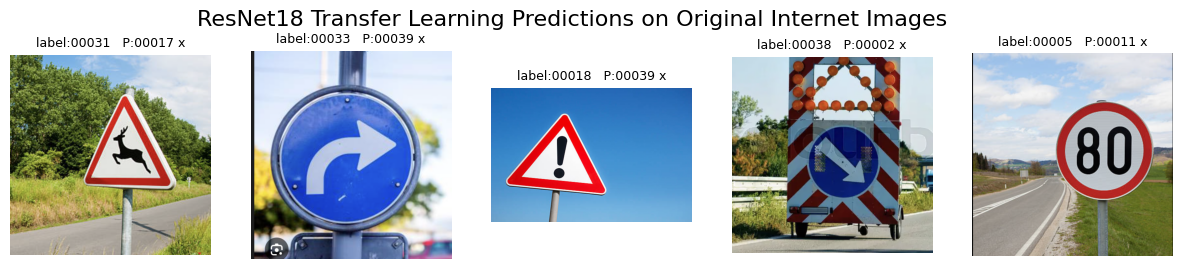

,file,label,pred,correct
0,"[[[30, 45, 7], [43, 57, 11], [68, 80, 27], [79...",00031,00017,False
1,"[[[30, 30, 30], [31, 31, 31], [30, 30, 30], [3...",00033,00039,False
2,"[[[25, 94, 171], [25, 94, 171], [25, 94, 171],...",00018,00039,False
3,"[[[192, 217, 230], [192, 217, 230], [192, 217,...",00038,00002,False
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [207, 219, ...",00005,00011,False


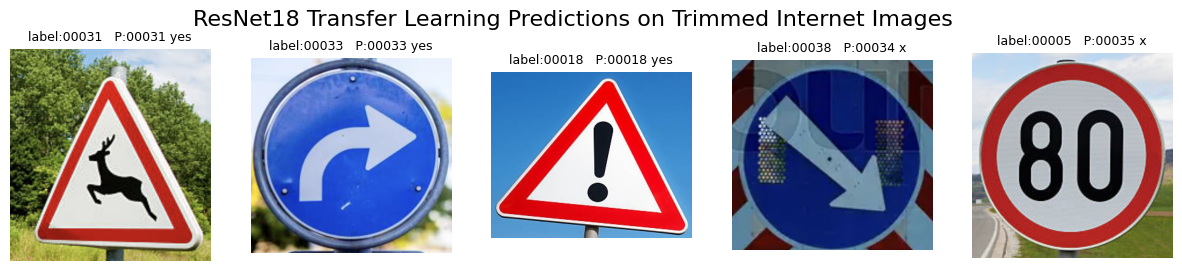

,file,label,pred,correct
0,"[[[104, 123, 52], [111, 131, 57], [87, 107, 39...",00031,00031,True
1,"[[[219, 232, 253], [220, 233, 253], [220, 233,...",00033,00033,True
2,"[[[34, 110, 185], [34, 110, 185], [34, 110, 18...",00018,00018,True
3,"[[[86, 129, 151], [86, 129, 151], [86, 129, 15...",00038,00034,False
4,"[[[233, 231, 235], [232, 231, 236], [230, 230,...",00005,00035,False


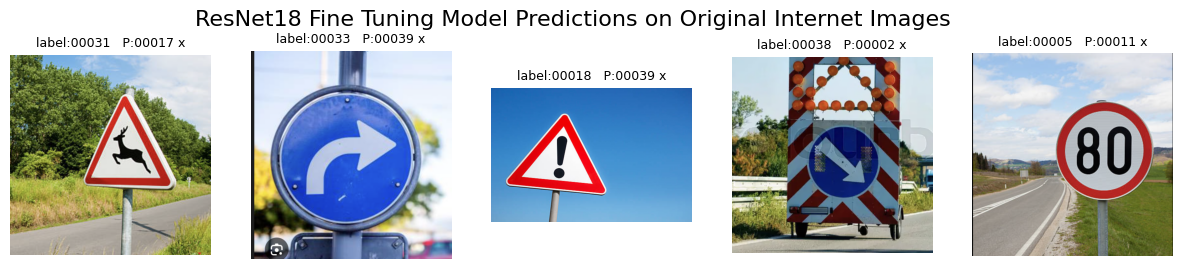

,file,label,pred,correct
0,"[[[30, 45, 7], [43, 57, 11], [68, 80, 27], [79...",00031,00017,False
1,"[[[30, 30, 30], [31, 31, 31], [30, 30, 30], [3...",00033,00039,False
2,"[[[25, 94, 171], [25, 94, 171], [25, 94, 171],...",00018,00039,False
3,"[[[192, 217, 230], [192, 217, 230], [192, 217,...",00038,00002,False
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [207, 219, ...",00005,00011,False


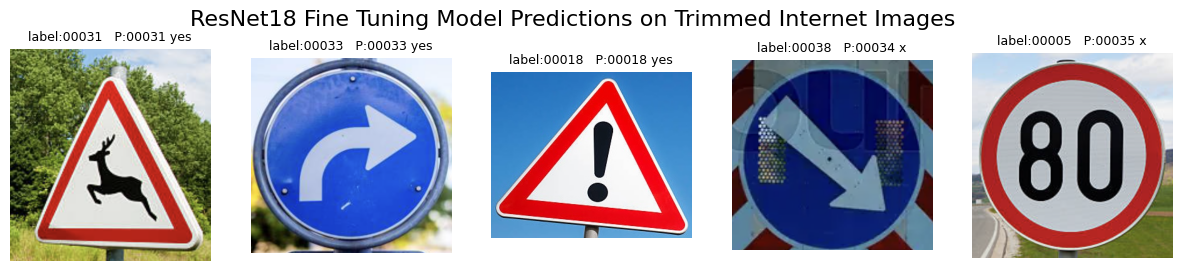

,file,label,pred,correct
0,"[[[104, 123, 52], [111, 131, 57], [87, 107, 39...",00031,00031,True
1,"[[[219, 232, 253], [220, 233, 253], [220, 233,...",00033,00033,True
2,"[[[34, 110, 185], [34, 110, 185], [34, 110, 18...",00018,00018,True
3,"[[[86, 129, 151], [86, 129, 151], [86, 129, 15...",00038,00034,False
4,"[[[233, 231, 235], [232, 231, 236], [230, 230,...",00005,00035,False


In [53]:
import os
from PIL import Image



def predict_internet_images(model, datamodule, device, images_dir, title):
    path = os.path.expanduser(images_dir)
    internet_images = os.listdir(path)

    model.to(device).eval()

    results = []
    fig, axes = plt.subplots(1, max(1, len(internet_images)), figsize=(len(internet_images)*3, 3))
    fig.suptitle(title, fontsize=16)

    for i, img in enumerate(internet_images):
        img_path = os.path.join(path, img)
        label = img.split('_')[0]  # label is before the first underscore

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil = Image.fromarray(img)

        x = datamodule.test_transform(pil).unsqueeze(0).to(device)  # add batch dimension and move to device

        with torch.no_grad():
            logits = model(x)

        pred_idx = int(logits.argmax(dim=1).cpu().item())
        pred_name = datamodule.train.classes[pred_idx]
        ok = pred_name == label

        results.append({"file": img, "label": label, "pred": pred_name, "correct": ok})

        # plot
        ax = axes[i]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"label:{label}   P:{pred_name} {'yes' if ok else 'x'}", fontsize=9)

    plt.show()
    return results


TEST_INTERNET_IMAGES_DIR = "~/src/tec/semestre_7_local/ds_ai_ml_models/neural_networks/cnn/internet_test_images/" # replace with your route


results = predict_internet_images(
    resnet_model_lightning,
    dm,
    device,
    TEST_INTERNET_IMAGES_DIR+'original',
    title="ResNet18 Transfer Learning Predictions on Original Internet Images"
)
display(pd.DataFrame(results))



results = predict_internet_images(
    resnet_model_lightning,
    dm,
    device,
    TEST_INTERNET_IMAGES_DIR+'trimmed',
    title="ResNet18 Transfer Learning Predictions on Trimmed Internet Images"
)
display(pd.DataFrame(results))


results = predict_internet_images(
    resnet_fine_tuning_model_lightning,
    fine_tuning_dm,
    device,
    TEST_INTERNET_IMAGES_DIR+'original',
    title="ResNet18 Fine Tuning Model Predictions on Original Internet Images"
)
display(pd.DataFrame(results))



results = predict_internet_images(
    resnet_fine_tuning_model_lightning,
    fine_tuning_dm,
    device,
    TEST_INTERNET_IMAGES_DIR+'trimmed',
    title="ResNet18 Fine Tuning Model Predictions on Trimmed Internet Images"
)
display(pd.DataFrame(results))



## Conclussions